In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Vector ODE with 2 parameter

$$ S' = -\beta SI \quad S(0) = 0.99 $$
$$ I' = \beta SI - \gamma I \quad I(0) = 0.01 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 2
n_odeparams = 2

data = make_test_data_4()
#Times to evaluate the solution
times = data['t']

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_4, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

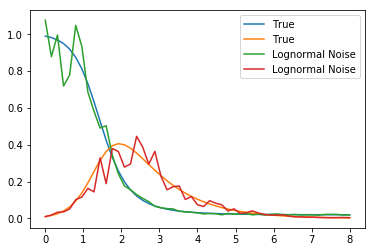

In [3]:
Ytrue = data['y']
Y = data['yobs']

plt.plot(times,Ytrue, label = 'True')
plt.plot(times,Y, label = 'Lognormal Noise')
plt.legend()



In [4]:

    
my_ODEop = ODEop(ode_model)


In [5]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    beta = pm.HalfNormal('beta',2)
    gamma = pm.HalfNormal('gamma',2)

    sigma = pm.HalfCauchy('sigma',1, shape = 2)

    # Forward model
    #[ODE Parameters, initial condition]
    all_params = pm.math.stack([beta, gamma,0.99, 0.01],axis=0)

    
    ode_sol = my_ODEop(all_params)

    
    forward = ode_sol.reshape(Y.shape)

    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gamma, beta]
Sampling 2 chains: 100%|██████████| 6000/6000 [28:21<00:00,  2.31draws/s] 


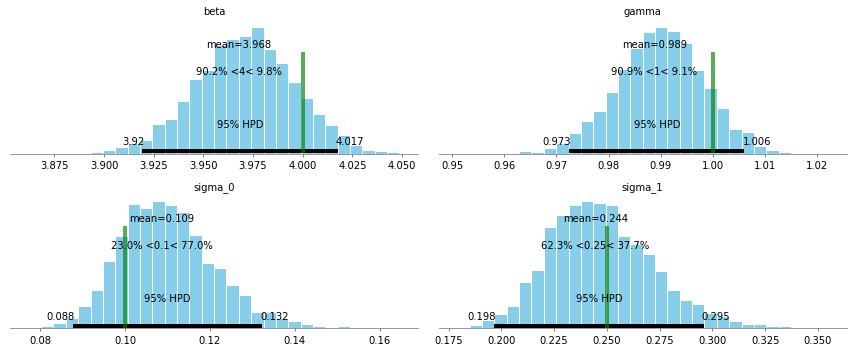

In [8]:
beta, gamma = data['p']
sigma1, sigma2 = data['sigma']

pm.posteriorplot.plot_posterior(trace, 
                                varnames=['beta', 'gamma','sigma'],
                                ref_val=[beta, gamma, sigma1, sigma2]
                                );

In [9]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'beta': 1.000536071549187,
 'gamma': 1.0001583958024511,
 'ode': array([0.99974997, 0.99974997, 1.00054736, 1.00055092, 1.0005527 ,
       1.00054941, 1.00055495, 1.00054773, 1.00055566, 1.00054581,
       1.00055574, 1.00054344, 1.00055573, 1.00054016, 1.00055592,
       1.0005347 , 1.00055636, 1.00052366, 1.00055682, 1.00049725,
       1.00055683, 1.00042369, 1.00055573, 1.00019694, 1.0005528 ,
       0.99978215, 1.00054729, 0.99990538, 1.00053832, 1.00015182,
       1.00052491, 1.00027291, 1.00050601, 1.00033145, 1.00048054,
       1.00036203, 1.00044765, 1.00037879, 1.00040692, 1.00038803,
       1.00035863, 1.00039287, 1.0003039 , 1.00039501, 1.0002447 ,
       1.00039542, 1.00018353, 1.0003947 , 1.00012311, 1.00039325,
       1.00006584, 1.00039132, 1.00001354, 1.00038909, 0.99996729,
       1.00038667, 0.99992748, 1.00038414, 0.99989395, 1.00038158,
       0.99986618, 1.00037901, 0.99984348, 1.00037648, 0.99982511,
       1.00037399, 0.99981034, 1.00037156, 0.99979852, 1.000369

In [10]:
with first_model:
    ppc = pm.sample_ppc(trace, 500)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:29<00:00, 16.86it/s]


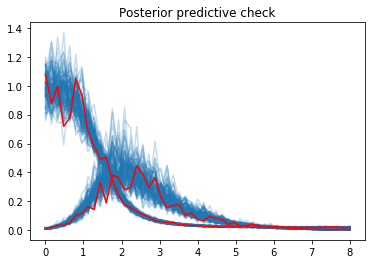

In [13]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.25)
    
plt.plot(times,Y, color = 'red')
plt.title('Posterior predictive check');

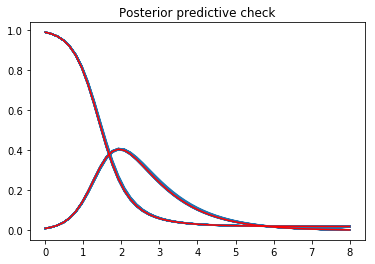

In [14]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i].reshape(Y.shape), color = 'C0', alpha = 0.5)
    
plt.plot(times,Ytrue, color = 'red')
plt.title('Posterior predictive check');